In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## 0. Load Data

In [2]:
data = pd.read_csv('../data/data.csv')


## 1. Data Analysis: First Sight

### How is the date distribuited?

## 2. Features Generation

### 2.a. Period of Day

In [3]:
from datetime import datetime

def get_period_day(date):
    date_time = datetime.strptime(date, '%Y-%m-%d %H:%M:%S').time()
    morning_min = datetime.strptime("05:00", '%H:%M').time()
    morning_max = datetime.strptime("11:59", '%H:%M').time()
    afternoon_min = datetime.strptime("12:00", '%H:%M').time()
    afternoon_max = datetime.strptime("18:59", '%H:%M').time()
    evening_min = datetime.strptime("19:00", '%H:%M').time()
    evening_max = datetime.strptime("23:59", '%H:%M').time()
    night_min = datetime.strptime("00:00", '%H:%M').time()
    night_max = datetime.strptime("4:59", '%H:%M').time()
    
    if(date_time > morning_min and date_time < morning_max):
        return 'mañana'
    elif(date_time > afternoon_min and date_time < afternoon_max):
        return 'tarde'
    elif(
        (date_time > evening_min and date_time < evening_max) or
        (date_time > night_min and date_time < night_max)
    ):
        return 'noche'

In [4]:
data['period_day'] = data['Fecha-I'].apply(get_period_day)

### 2.b. High Season

In [5]:
from datetime import datetime

def is_high_season(fecha):
    fecha_año = int(fecha.split('-')[0])
    fecha = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
    range1_min = datetime.strptime('15-Dec', '%d-%b').replace(year = fecha_año)
    range1_max = datetime.strptime('31-Dec', '%d-%b').replace(year = fecha_año)
    range2_min = datetime.strptime('1-Jan', '%d-%b').replace(year = fecha_año)
    range2_max = datetime.strptime('3-Mar', '%d-%b').replace(year = fecha_año)
    range3_min = datetime.strptime('15-Jul', '%d-%b').replace(year = fecha_año)
    range3_max = datetime.strptime('31-Jul', '%d-%b').replace(year = fecha_año)
    range4_min = datetime.strptime('11-Sep', '%d-%b').replace(year = fecha_año)
    range4_max = datetime.strptime('30-Sep', '%d-%b').replace(year = fecha_año)
    
    if ((fecha >= range1_min and fecha <= range1_max) or 
        (fecha >= range2_min and fecha <= range2_max) or 
        (fecha >= range3_min and fecha <= range3_max) or
        (fecha >= range4_min and fecha <= range4_max)):
        return 1
    else:
        return 0

In [6]:
data['high_season'] = data['Fecha-I'].apply(is_high_season)

### 2.c. Difference in Minutes

In [7]:
def get_min_diff(data):
    fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    min_diff = ((fecha_o - fecha_i).total_seconds())/60
    return min_diff

In [8]:
data['min_diff'] = data.apply(get_min_diff, axis = 1)

### 2.d. Delay

In [9]:
threshold_in_minutes = 15
data['delay'] = np.where(data['min_diff'] > threshold_in_minutes, 1, 0)

## 3. Data Analysis: Second Sight

### How is the delay rate across columns?

## 4. Training

### 4.a. Data Split (Training and Validation)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
training_data = shuffle(data[['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'delay']], random_state = 111)

In [12]:
features = pd.concat([
    pd.get_dummies(data['OPERA'], prefix = 'OPERA'),
    pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), 
    pd.get_dummies(data['MES'], prefix = 'MES')], 
    axis = 1
)
target = data['delay']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.33, random_state = 42)

In [14]:
print(f"train shape: {x_train.shape} | test shape: {x_test.shape}")

train shape: (45698, 37) | test shape: (22508, 37)


In [15]:
y_train.value_counts('%')*100

delay
0    81.618452
1    18.381548
Name: proportion, dtype: float64

In [16]:
y_test.value_counts('%')*100

delay
0    81.277768
1    18.722232
Name: proportion, dtype: float64

### 4.b. Model Selection

#### 4.b.i. XGBoost

In [17]:
import xgboost as xgb
from xgboost import plot_importance

In [18]:
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [19]:
xgboost_y_preds = xgb_model.predict(x_test)
xgboost_y_preds = [1 if y_pred > 0.5 else 0 for y_pred in xgboost_y_preds]

In [20]:
confusion_matrix(y_test, xgboost_y_preds)

array([[18294,     0],
       [ 4214,     0]])

In [21]:
print(classification_report(y_test, xgboost_y_preds))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.00      0.00      0.00      4214

    accuracy                           0.81     22508
   macro avg       0.41      0.50      0.45     22508
weighted avg       0.66      0.81      0.73     22508



#### 4.b.ii. Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
reg_model = LogisticRegression()
reg_model.fit(x_train, y_train)

LogisticRegression()

In [24]:
reg_y_preds = reg_model.predict(x_test)

In [25]:
confusion_matrix(y_test, reg_y_preds)

array([[18193,   101],
       [ 4086,   128]])

In [26]:
print(classification_report(y_test, reg_y_preds))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18294
           1       0.56      0.03      0.06      4214

    accuracy                           0.81     22508
   macro avg       0.69      0.51      0.48     22508
weighted avg       0.77      0.81      0.74     22508



## 5. Data Analysis: Third Sight

### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1000x500 with 0 Axes>

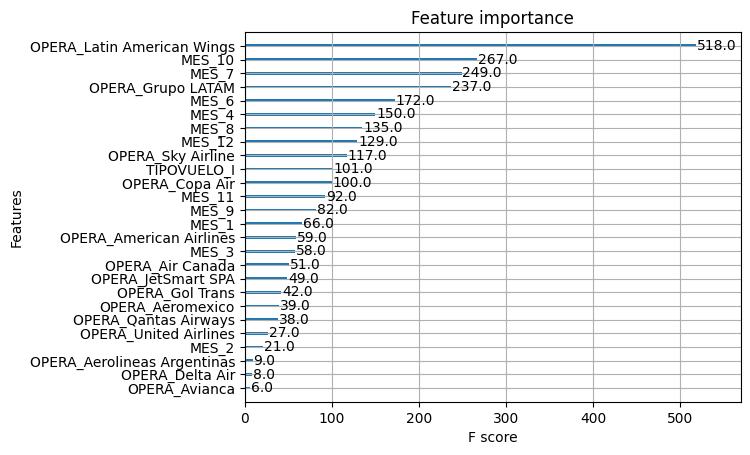

In [27]:
plt.figure(figsize = (10,5))
plot_importance(xgb_model)

In [28]:
top_10_features = [
    "OPERA_Latin American Wings", 
    "MES_7",
    "MES_10",
    "OPERA_Grupo LATAM",
    "MES_12",
    "TIPOVUELO_I",
    "MES_4",
    "MES_11",
    "OPERA_Sky Airline",
    "OPERA_Copa Air"
]

### Data Balance

In [29]:
n_y0 = len(y_train[y_train == 0])
n_y1 = len(y_train[y_train == 1])
scale = n_y0/n_y1
print(scale)

4.4402380952380955


## 6. Training with Improvement

### 6.a. Data Split

In [30]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(features[top_10_features], target, test_size = 0.33, random_state = 42)

### 6.b. Model Selection

#### 6.b.i. XGBoost with Feature Importance and with Balance

In [31]:
xgb_model_2 = xgb.XGBClassifier(random_state=1, learning_rate=0.01, scale_pos_weight = scale)
xgb_model_2.fit(x_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [32]:
xgboost_y_preds_2 = xgb_model_2.predict(x_test2)

In [33]:
confusion_matrix(y_test2, xgboost_y_preds_2)

array([[9556, 8738],
       [1313, 2901]])

In [34]:
print(classification_report(y_test2, xgboost_y_preds_2))

              precision    recall  f1-score   support

           0       0.88      0.52      0.66     18294
           1       0.25      0.69      0.37      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.61      0.51     22508
weighted avg       0.76      0.55      0.60     22508



#### 6.b.ii. XGBoost with Feature Importance but without Balance

In [35]:
xgb_model_3 = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
xgb_model_3.fit(x_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [36]:
xgboost_y_preds_3 = xgb_model_3.predict(x_test2)

In [37]:
confusion_matrix(y_test2, xgboost_y_preds_3)

array([[18286,     8],
       [ 4188,    26]])

In [38]:
print(classification_report(y_test2, xgboost_y_preds_3))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.76      0.01      0.01      4214

    accuracy                           0.81     22508
   macro avg       0.79      0.50      0.45     22508
weighted avg       0.80      0.81      0.73     22508



## 7. Data Science Conclusions

By looking at the results of the 6 trained models, it can be determined:
- There is no noticeable difference in results between XGBoost and LogisticRegression.
- Does not decrease the performance of the model by reducing the features to the 10 most important.
- Improves the model's performance when balancing classes, since it increases the recall of class "1".

**With this, the model to be productive must be the one that is trained with the top 10 features and class balancing, but which one?**

In [39]:
import joblib

# Guarda el modelo en un archivo
joblib.dump(xgb_model_2, 'modelo_xgboost.pkl')


['modelo_xgboost.pkl']